Loading Iris dataset from sklearn (default).
Feature shape: (150, 4)
Number of classes: 3
Train shape: (120, 4), Test shape: (30, 4)

Accuracy results for K values:
     k  accuracy
0    1  0.966667
1    2  0.933333
2    3  0.933333
3    4  0.933333
4    5  0.933333
5    6  0.933333
6    7  0.966667
7    8  0.933333
8    9  0.966667
9   10  0.966667
10  11  0.966667
11  12  0.966667
12  13  0.966667
13  14  0.966667
14  15  0.966667
15  16  0.966667
16  17  0.966667
17  18  0.966667
18  19  0.966667
19  20  0.966667

Best k: 1 with accuracy = 0.9667

Classification Report (best k):
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        10
           1     0.9091    1.0000    0.9524        10
           2     1.0000    0.9000    0.9474        10

    accuracy                         0.9667        30
   macro avg     0.9697    0.9667    0.9666        30
weighted avg     0.9697    0.9667    0.9666        30

Confusion Matrix (rows=actual,

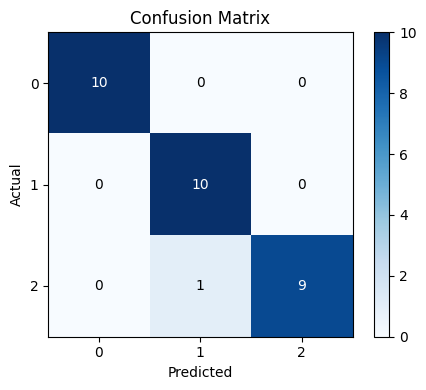

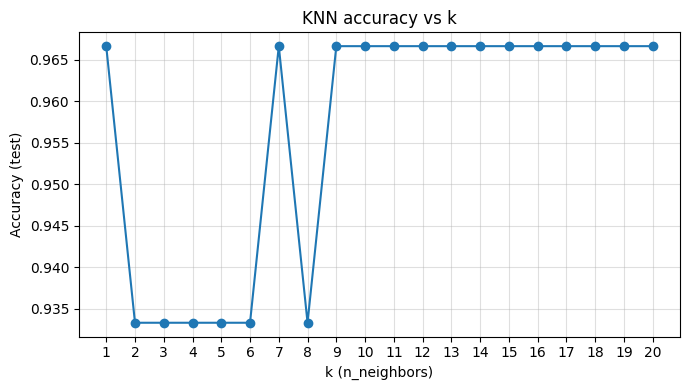

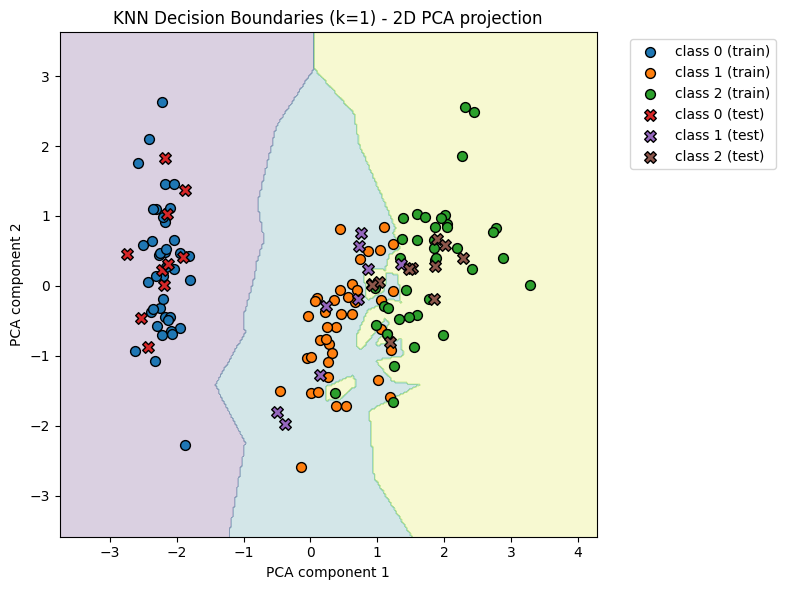


Saved knn_k_vs_accuracy.csv

Notes / Tips:
- Normalize/scale features before KNN (important).
- Use cross-validation to pick k more robustly (GridSearchCV with cross_val_score).
- For large datasets KNN can be slow at prediction time; consider KDTree/ball_tree options
  (look at KNeighborsClassifier parameters) or approximate nearest neighbors libraries.
- Decision boundary visualization here uses PCA to reduce to 2D for intuition only.



In [1]:
# K-Nearest Neighbors (KNN) Classification - Complete Example
# - Default dataset: Iris (sklearn)
# - Optionally load local CSV by setting USE_LOCAL_CSV=True and providing LOCAL_CSV_PATH
# - Normalizes features, tries multiple k values, evaluates and plots decision boundaries (2D)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

# ====== CONFIG ======
USE_LOCAL_CSV = False
# If you want to use a file you uploaded, you can reference it here.
# Note: the uploaded image path from this session is '/mnt/data/53048.jpg'.
# Replace with your CSV path (e.g., '/mnt/data/your_dataset.csv') when using CSV.
LOCAL_CSV_PATH = '/mnt/data/53048.jpg'
TARGET_COLUMN = 'target'   # set to your target column name if using CSV
TEST_SIZE = 0.2
RANDOM_STATE = 42
K_VALUES = list(range(1, 21))  # k values to try

# ====== Load data ======
if USE_LOCAL_CSV:
    print(f"Loading local CSV: {LOCAL_CSV_PATH}")
    df = pd.read_csv(LOCAL_CSV_PATH)
    if TARGET_COLUMN not in df.columns:
        raise ValueError(f"TARGET_COLUMN '{TARGET_COLUMN}' not found in CSV columns.")
    X = df.drop(columns=[TARGET_COLUMN]).values
    y = df[TARGET_COLUMN].values
    feature_names = df.drop(columns=[TARGET_COLUMN]).columns.tolist()
else:
    print("Loading Iris dataset from sklearn (default).")
    iris = load_iris()
    X = iris.data
    y = iris.target
    feature_names = iris.feature_names

print("Feature shape:", X.shape)
print("Number of classes:", len(np.unique(y)))

# ====== Train/test split ======
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# ====== Standardize features ======
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ====== Try multiple k values and evaluate ======
results = []
for k in K_VALUES:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    results.append({'k': k, 'accuracy': acc})

res_df = pd.DataFrame(results)
best_row = res_df.loc[res_df['accuracy'].idxmax()]
print("\nAccuracy results for K values:")
print(res_df)

print(f"\nBest k: {int(best_row['k'])} with accuracy = {best_row['accuracy']:.4f}")

# ====== Fit best model and show classification report/confusion matrix ======
best_k = int(best_row['k'])
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train_scaled, y_train)
y_pred_best = best_knn.predict(X_test_scaled)

print("\nClassification Report (best k):")
print(classification_report(y_test, y_pred_best, digits=4))

cm = confusion_matrix(y_test, y_pred_best)
print("Confusion Matrix (rows=actual, cols=predicted):")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = [str(c) for c in np.unique(y)]
plt.xticks(range(len(classes)), classes)
plt.yticks(range(len(classes)), classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, v, ha='center', va='center', color='white' if v > cm.max()/2 else 'black')
plt.tight_layout()
plt.show()

# ====== Plot accuracy vs k ======
plt.figure(figsize=(7,4))
plt.plot(res_df['k'], res_df['accuracy'], marker='o')
plt.xlabel('k (n_neighbors)')
plt.ylabel('Accuracy (test)')
plt.title('KNN accuracy vs k')
plt.grid(alpha=0.4)
plt.xticks(K_VALUES)
plt.tight_layout()
plt.show()

# ====== Decision boundary visualization (2D via PCA) ======
# This visualizes approximate boundaries by projecting to 2D with PCA.
# Only for intuition — actual decision boundaries in original space are higher-dim.
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_proj = pca.fit_transform(np.vstack([X_train_scaled, X_test_scaled]))
Xtr_proj = X_proj[:len(X_train_scaled)]
Xts_proj = X_proj[len(X_train_scaled):]

# Retrain on projected 2D data for visualization only
knn_2d = KNeighborsClassifier(n_neighbors=best_k)
knn_2d.fit(Xtr_proj, y_train)

# Create meshgrid
x_min, x_max = X_proj[:,0].min() - 1, X_proj[:,0].max() + 1
y_min, y_max = X_proj[:,1].min() - 1, X_proj[:,1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = knn_2d.predict(grid)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, alpha=0.2)
# plot train points
for cls in np.unique(y):
    idx = np.where(y_train == cls)
    plt.scatter(Xtr_proj[idx,0], Xtr_proj[idx,1], edgecolor='k', s=50, label=f'class {cls} (train)')
# plot test points with markers
for cls in np.unique(y):
    idx = np.where(y_test == cls)
    plt.scatter(Xts_proj[idx,0], Xts_proj[idx,1], marker='X', s=70, edgecolor='k', label=f'class {cls} (test)')
plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')
plt.title(f'KNN Decision Boundaries (k={best_k}) - 2D PCA projection')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# ====== Save results (optional) ======
res_df.to_csv('knn_k_vs_accuracy.csv', index=False)
print("\nSaved knn_k_vs_accuracy.csv")

# ====== Notes ======
notes = """
Notes / Tips:
- Normalize/scale features before KNN (important).
- Use cross-validation to pick k more robustly (GridSearchCV with cross_val_score).
- For large datasets KNN can be slow at prediction time; consider KDTree/ball_tree options
  (look at KNeighborsClassifier parameters) or approximate nearest neighbors libraries.
- Decision boundary visualization here uses PCA to reduce to 2D for intuition only.
"""
print(notes)
